In [ ]:
import os
import pandas as pd
import numpy as np
from functools import reduce
from backtest import run_all_windows


HP_MINIBATCH_SIZE = [64, 128, 256]
TICKERS = ['ADM', 'ALB', 'ALCO', 'AMZN', 'BA', 'BAC', 'BG', 'BKNG', 'C', 'CAH', 'CMCSA', 'DHI', 'DIS', 'DUK', 'FCX', 'FDP',
           'GOOGL', 'GPC', 'GS', 'GWW', 'HSIC', 'INTC', 'JPM', 'KO', 'LEN', 'LMNR', 'MCK', 'META', 'NEE', 'NEM', 'NVR',
           'PEP', 'PG', 'PHM', 'RGLD', 'SCCO', 'T', 'TOL', 'TWX', 'VZ', 'WFC', 'WMT']
MODLE_PARAMS = {
    "architecture": "TFT",
    "total_time_steps": 252,
    "early_stopping_patience": 25,
    "multiprocessing_workers": 32,
    "num_epochs": 150,
    "early_stopping_patience": 25,
    "fill_blank_dates": False,
    "split_tickers_individually": True,
    "random_search_iterations": 15,
    "evaluate_diversified_val_sharpe": True,
    "train_valid_ratio": 0.90,
    "time_features": False,
    "force_output_sharpe_length": 0,
}


TEST_MODE = True
ASSET_CLASS_MAPPING = dict(zip(TICKERS, ["STOCK"] * len(TICKERS)))
TRAIN_VALID_RATIO = 0.9
TIME_FEATURES = False
FORCE_OUTPUT_SHARPE_LENGTH = None
EVALUATE_DIVERSIFIED_VAL_SHARPE = True
NAME = "stock"

In [ ]:
folder_path = "Data/Finished_Datasets/"
combined_data = []

for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        file_path = os.path.join(folder_path, file_name)
        data = pd.read_csv(file_path)

        combined_data.append(data)


combined_df = pd.concat(combined_data, ignore_index=True)

combined_df = combined_df.drop(columns=["close", "srs"])


combined_df.to_csv("Data/full_data.csv", index=False)

In [5]:
def run_test(experiment: str, train_start: int, test_start: int, test_end: int, test_window_size: int, num_repeats: int):

    if experiment == "LSTM":
        architecture = "LSTM"
        lstm_time_steps = 63
        changepoint_lbws = [21]
    elif experiment == "TFT":
        architecture = "TFT"
        lstm_time_steps = 252
        changepoint_lbws = [21]
    elif experiment == "TFT-SHORT":
        architecture = "TFT"
        lstm_time_steps = 63
        changepoint_lbws = [21]
    else:
        raise BaseException("Invalid experiment.")

    versions = range(1, 1 + num_repeats) if not TEST_MODE else [1]

    experiment_prefix = (
        NAME
        + ("_TEST" if TEST_MODE else "")
        + ("" if TRAIN_VALID_RATIO == 0.90 else f"_split{int(TRAIN_VALID_RATIO * 100)}")
    )

    cp_string = (
        "none"
        if not changepoint_lbws
        else reduce(lambda x, y: str(x) + str(y), changepoint_lbws)
    )
    time_string = "time" if TIME_FEATURES else "notime"
    _project_name = f"{experiment_prefix}_{architecture.lower()}_cp{cp_string}_len{lstm_time_steps}_{time_string}_{'div' if EVALUATE_DIVERSIFIED_VAL_SHARPE else 'val'}"

    if FORCE_OUTPUT_SHARPE_LENGTH:
        _project_name += f"_outlen{FORCE_OUTPUT_SHARPE_LENGTH}"
    _project_name += "_v"

    for v in versions:
        PROJECT_NAME = _project_name + str(v)

        intervals = [
            (train_start, y, y + test_window_size)
            for y in range(test_start, test_end)
        ]


        params = MODLE_PARAMS.copy()
        params["total_time_steps"] = lstm_time_steps
        params["architecture"] = architecture
        params["evaluate_diversified_val_sharpe"] = EVALUATE_DIVERSIFIED_VAL_SHARPE
        params["train_valid_ratio"] = TRAIN_VALID_RATIO
        params["time_features"] = TIME_FEATURES
        params["force_output_sharpe_length"] = FORCE_OUTPUT_SHARPE_LENGTH


        if TEST_MODE:
            params["num_epochs"] = 1
            params["random_search_iterations"] = 2

        features_file_path = "Data/full_data.csv"

        run_all_windows(
            PROJECT_NAME,
            features_file_path,
            intervals,
            params,
            changepoint_lbws,
            ASSET_CLASS_MAPPING,
            [32, 64, 128] if lstm_time_steps == 252 else HP_MINIBATCH_SIZE,
            test_window_size,
        )



In [6]:
run_test("LSTM", 2017, 2020, 2024, 1, 1)

Trial 2 Complete [00h 00m 02s]
sharpe: 0.3122530635144205

Best sharpe So Far: 1.001076794919651
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit
Best validation loss = 16.565637689190037
Best params:
hidden_layer_size = 160
dropout_rate = 0.1
max_gradient_norm = 0.01
learning_rate = 0.01
batch_size = 64
Predicting on test set...
performance (sliding window) = 2.574558157545273
performance (fixed window) = 2.6047693119307955
time
2020-01-02    0.014101
2020-01-03    0.010475
2020-01-06    0.010655
2020-01-07    0.014267
2020-01-08    0.007342
                ...   
2020-12-24    0.015555
2020-12-28    0.007595
2020-12-29    0.011972
2020-12-30    0.017195
2020-12-31    0.012178
Name: captured_returns, Length: 253, dtype: float64
253
time
2020-01-02    0.014101
2020-01-03    0.010462
2020-01-06    0.010646
2020-01-07    0.014258
2020-01-08    0.007332
                ...   
2020-12-24    0.015549
2020-12-28    0.007590
2020-12-29    0.011966
2020-12-30    0.017190
2

KeyboardInterrupt: 

In [ ]:
raw_data = pd.read_csv("Data/full_data.csv", index_col=0, parse_dates=True)
raw_data.rename(columns={'date.1': 'date'}, inplace=True)
raw_data["date"] = raw_data["date"].astype("datetime64[ns]")

In [ ]:
df = raw_data.dropna()
df = df[df["year"] >= 2017].copy()
years = df["year"]

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
import os
os.environ['CUDA_HOME'] = r"C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2"
os.environ['PATH'] += r";C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin"
os.environ['PATH'] += r";C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/extras/CUPTI/libx64"
os.environ['PATH'] += r";C:/tools/cuda/bin"

In [ ]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices("GPU")
if physical_devices:
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth set for GPUs.")
    except RuntimeError as e:
        print("Error setting memory growth:", e)
else: print("No GPUs found.")

Memory growth set for GPUs.


In [ ]:
import tensorflow as tf

print(tf.__version__)

2.10.0


In [ ]:
test = "results\stocks_TEST_lstm_cp21_len63_notime_div_v1\2019-2020\hp\experiment_stocks_TEST_lstm_cp21_len63_notime_div_v1\trial_411433bdbcbf8165d1cbd9e69e534202\checkpoints\epoch_0\checkpoint_temp/part-00000-of-00001.data-00000-of-00001.tempstate1022316393468577740"

In [ ]:
os.path.normpath(test)

'results\\stocks_TEST_lstm_cp21_len63_notime_div_v1\x819-2020\\hp\\experiment_stocks_TEST_lstm_cp21_len63_notime_div_v1\trial_411433bdbcbf8165d1cbd9e69e534202\\checkpoints\\epoch_0\\checkpoint_temp\\part-00000-of-00001.data-00000-of-00001.tempstate1022316393468577740'

In [14]:
import pandas as pd

# Load the data
file_path = 'results/stock_lstm_cp21_len63_notime_div_v1/2020-2021/captured_returns_fw.csv'
df = pd.read_csv(file_path)

# Check the first few rows to understand the structure

# Calculate cumulative returns
num_identifiers = None

if not num_identifiers:
        num_identifiers = len(df.dropna()["identifier"].unique())
    

srs = df.dropna().groupby('time')["captured_returns"].sum() / num_identifiers

total_captured_returns = df.groupby('time')['position'].sum()


#total_captured_returns = (1 + srs).cumprod()

# Output the cumulative returns over time
#total_captured_returns



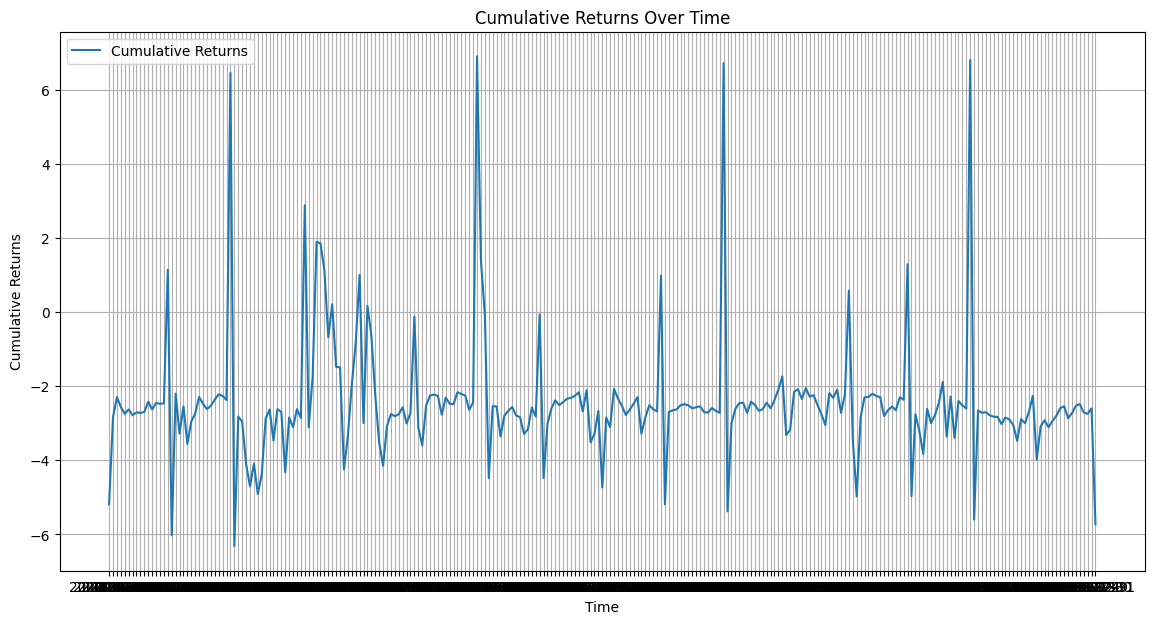

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(total_captured_returns, label='Cumulative Returns')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns Over Time')
plt.legend()
plt.grid(True)
plt.show()